# Wakefield example

Simple 1 m drift with a wakefield. 

This verifies that the analytic formula uses is SLAC-PUB-9663 Eq. 8



In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# locate the drift template
from impact import Impact, template_dir

ifile = os.path.join(template_dir, 'wakefield/ImpactT.in')
os.path.exists(ifile)

True

In [3]:
# gamma for 1 GeV
1e9/0.511e6

1956.9471624266146

# Use Impact's built-in Gaussian particle generator

In [4]:
I = Impact(ifile)
I.header['Np'] = 10000
I.header['Nx'] = 32
I.header['Ny'] = 32
I.header['Nz'] = 32
I.header['Dt'] = 10e-12

In [5]:
I.lattice

[{'description': 'name:sc_off',
  'original': '0 0 0 -8 0 -1 0 /!name:sc_off',
  'type': 'spacecharge',
  's': 0.0,
  'is_on': False,
  'name': 'sc_off'},
 {'type': 'comment',
  'description': '!0 0 0 -5 0 0 -1000.0 /!name:2d_to_3d_spacecharge',
  'name': '2d_to_3d_spacecharge'},
 {'description': 'name:wakefield_1',
  'original': '0 -1 0 -6 1 1 0.0 1.0 0.0116 0.0292 0.035 /!name:wakefield_1',
  'type': 'wakefield',
  's_begin': 0.0,
  's': 1.0,
  'method': 'analytical',
  'iris_radius': 0.0116,
  'gap': 0.0292,
  'period': 0.035,
  'name': 'wakefield_1'},
 {'description': 'name:drift_1',
  'original': '1.0 0 0 0 1.0 0.15 /!name:drift_1',
  'L': 1.0,
  'type': 'drift',
  'zedge': 1.0,
  'radius': 0.15,
  's': 2.0,
  'name': 'drift_1'},
 {'description': 'name:stop_1',
  'original': '0 0 0 -99 0 0.0 1 /!name:stop_1',
  'type': 'stop',
  's': 1.0,
  'name': 'stop_1'}]

In [6]:
I.run()

In [7]:
I.output['stats'].keys()

dict_keys(['t', 'mean_z', 'moment4_x', 'moment4_y', 'moment4_z', 'mean_y', 'sigma_y', 'norm_emit_y', 'mean_x', 'sigma_x', 'norm_emit_x', 'sigma_z', 'norm_emit_z', 'loadbalance_min_n_particle', 'loadbalance_max_n_particle', 'n_particle', 'moment3_x', 'moment3_y', 'moment3_z', 'mean_gamma', 'mean_beta', 'max_r', 'sigma_gamma', 'max_amplitude_x', 'max_amplitude_y', 'max_amplitude_z', 'moment4_px', 'moment4_py', 'moment4_pz', 'mean_py', 'sigma_py', 'cov_y__py', 'mean_px', 'sigma_px', 'cov_x__px', 'mean_pz', 'sigma_pz', 'cov_z__pz', 'moment3_px', 'moment3_py', 'moment3_pz', 'mean_kinetic_energy', 'max_amplitude_px', 'max_amplitude_py', 'max_amplitude_pz'])

In [8]:
PI = I.particles['initial_particles']
PF = I.particles['final_particles']
PI, PF

(<ParticleGroup with 10000 particles at 0x15e0bae50>,
 <ParticleGroup with 10000 particles at 0x15e0ba0d0>)

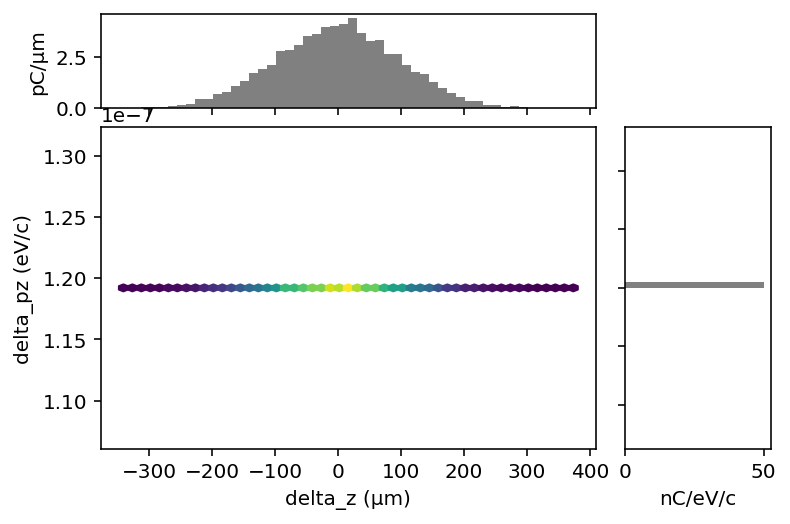

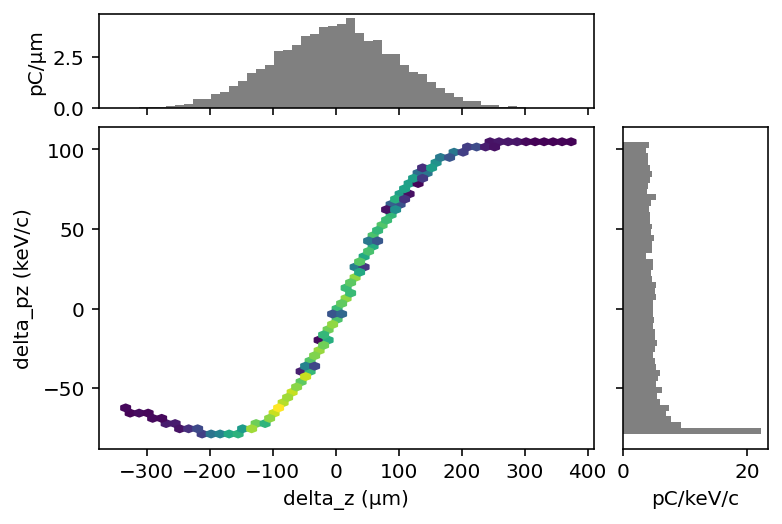

In [9]:
PI.plot('delta_z', 'delta_pz')
PF.plot('delta_z', 'delta_pz')

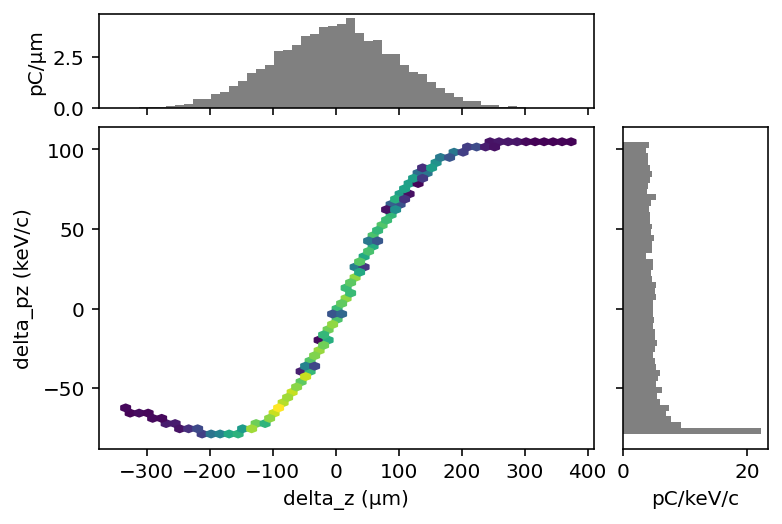

In [10]:
PF.plot('delta_z', 'delta_pz')

In [11]:
#np.savetxt('/Users/chrisonian/Scratch/impactwake.dat', np.array([PF['z'], PF['pz']]).T)

# Make particles in distgen

In [12]:
from distgen import Generator

YAML="""
n_particle: 20000
random_type: hammersley
start:
  tstart:
    units: sec
    value: 0
  type: time
total_charge:
  units: nC
  value: 1
r_dist:
  sigma_xy:
    units: mm
    value: .001
  type: radial_gaussian
z_dist:
  avg_z:
    units: mm
    value: 0
  sigma_z:
    units: mm
    value: 0.1
  type: gaussian
  

transforms:
  setPz:
    type: set_avg pz
    avg_pz: 
      value: 1
      units: GeV/c
  
"""
G = Generator(YAML)
G.run()
P = G.particles


In [13]:
I = Impact(ifile, initial_particles=P, verbose=False)
I.run()
PF2 = I.particles['final_particles']

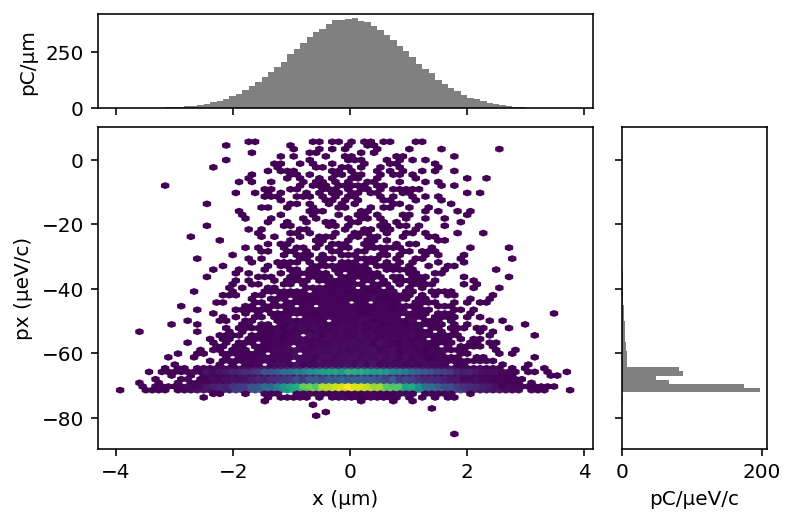

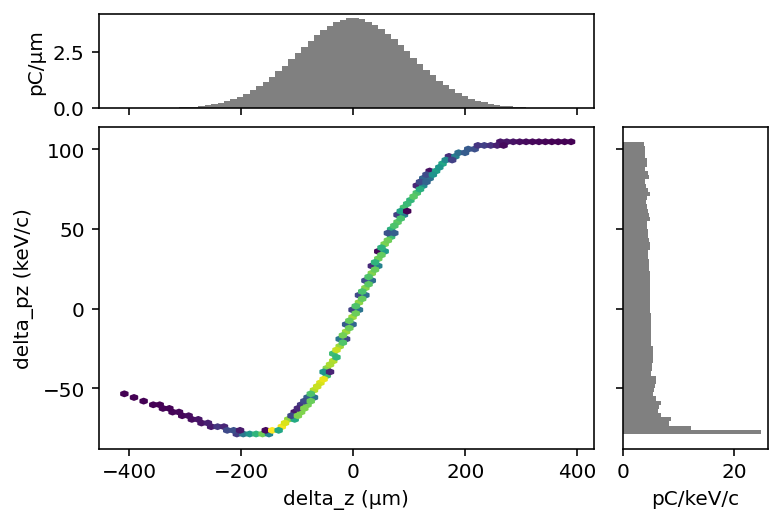

In [14]:
PF2.plot('x', 'px')
PF2.plot('delta_z', 'delta_pz')

# Compare

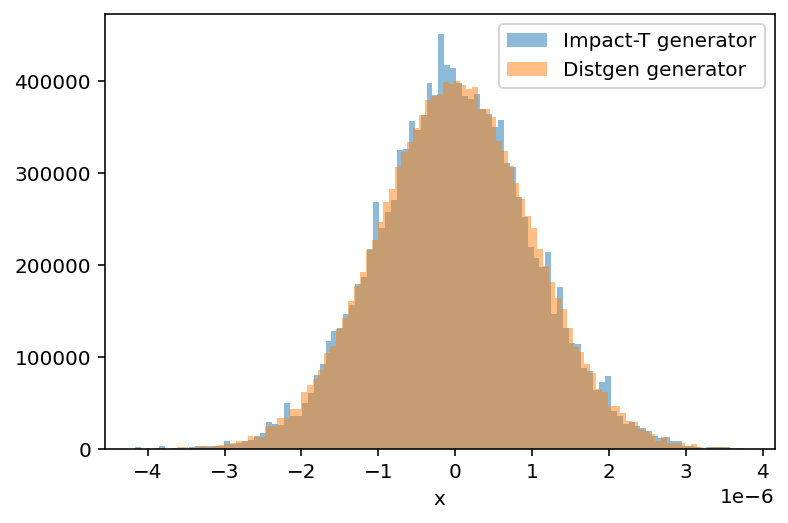

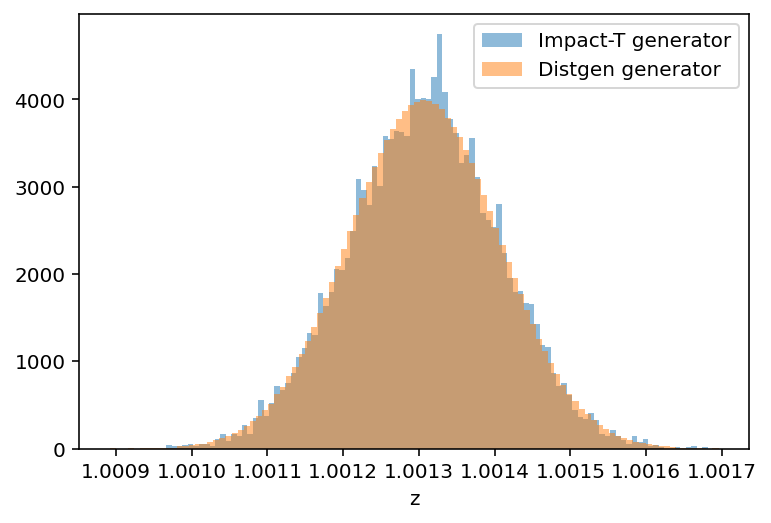

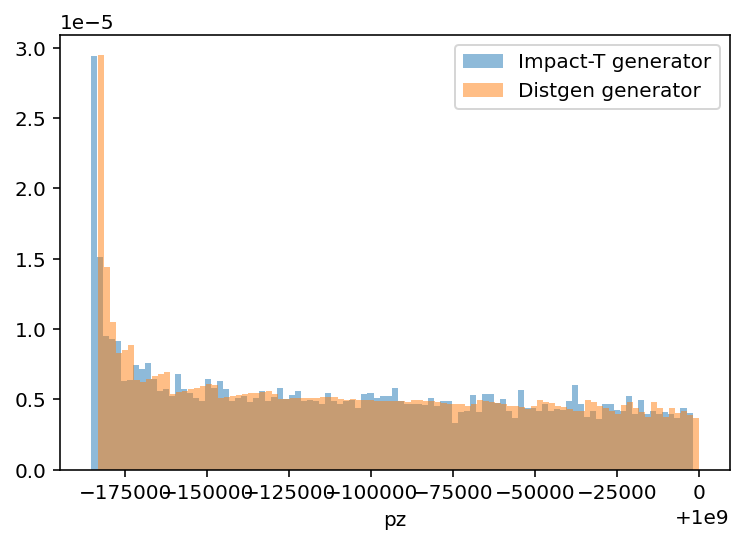

In [15]:
for k in ['x', 'z', 'pz']:
    plt.hist(PF[k], density=True, bins=100, label='Impact-T generator', alpha=0.5)
    plt.hist(PF2[k], density=True, bins=100, label='Distgen generator', alpha=0.5)
    plt.xlabel(k)
    plt.legend()
    plt.show()

 # Checking the wakefield with SLAC-PUB-9663
 
 Impact-T seems to use Eq. * from SLAC-PUB-9663, Karl Bane (2003). 
 
 https://www.slac.stanford.edu/pubs/slacpubs/9500/slac-pub-9663.pdf
 
 

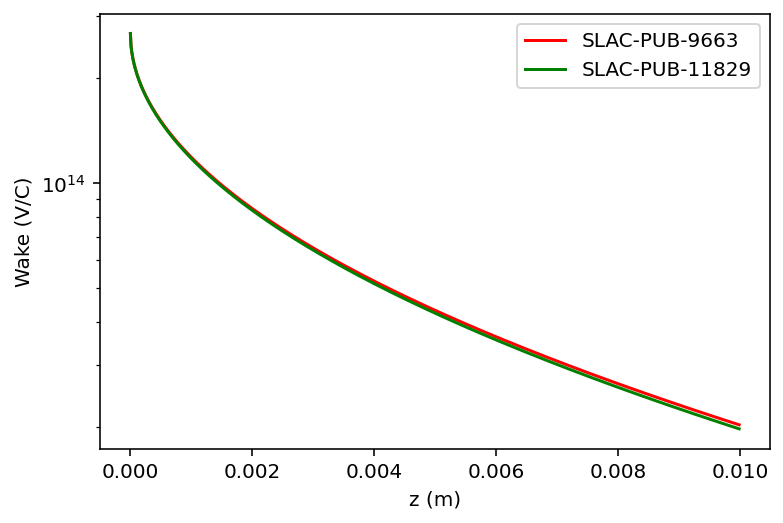

In [16]:
# Define alpha function for the s00 calc. 

def alpha(g):
    """
    SLAC-PUB-9663 equation (5)
    
    """
    a1 = 0.4648
    return 1 - a1*np.sqrt(g) - (1-2*a1)*g

def bane_wake(z, a=0.0116, g=0.0292, L=0.035):
    Z0 = 120.0 * np.pi
    
    s00 = g/8 * (a/(alpha(g/L)*L))**2
    
  #   'iris_radius': 0.0116,
  #   'gap': 0.0292,
  #   'period': 0.035,

    Z0c_over_pi = 120 * 299792458. # Ohm m/s

    WL = Z0c_over_pi/a**2 * np.exp(-np.sqrt(z/s00))

    return WL

def bane_wake2(z, a=0.0116, g=0.0292, L=0.035):
    
    """
    From SLAC-PUB-11829
    """
    Z0 = 120.0 * np.pi
    
    s1 = 0.41 * a**1.8 * g**1.6 / L**2.4

    Z0c_over_pi = 120 * 299792458. # Ohm m/s

    WL = Z0c_over_pi/a**2 * np.exp(-np.sqrt(z/s1))

    return WL

plt.xlabel('z (m)')
plt.ylabel('Wake (V/C)')
plt.yscale('log')

dzz = .00001
zz = np.arange(0, 0.01, dzz)

plt.yscale('log')
plt.plot(zz, bane_wake(zz), label='SLAC-PUB-9663', color='red')
plt.plot(zz, bane_wake2(zz), label='SLAC-PUB-11829', color='green')
plt.legend()

In [17]:
# Compare with particles
sigma = .0001
Qtot = -1e-9 # C 
def density(z, sigma=0.0001):
    
    return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*(z/sigma)**2)

dz = sigma/10
zlist = np.arange(-6*sigma, 6*sigma, dz)

# Check normalization
np.sum(density(zlist)) * dz

0.9999999979663955

In [18]:
def total_bane_wake(z):
    W = bane_wake(zz)
    return np.sum(W * density(zz + z)*dzz)

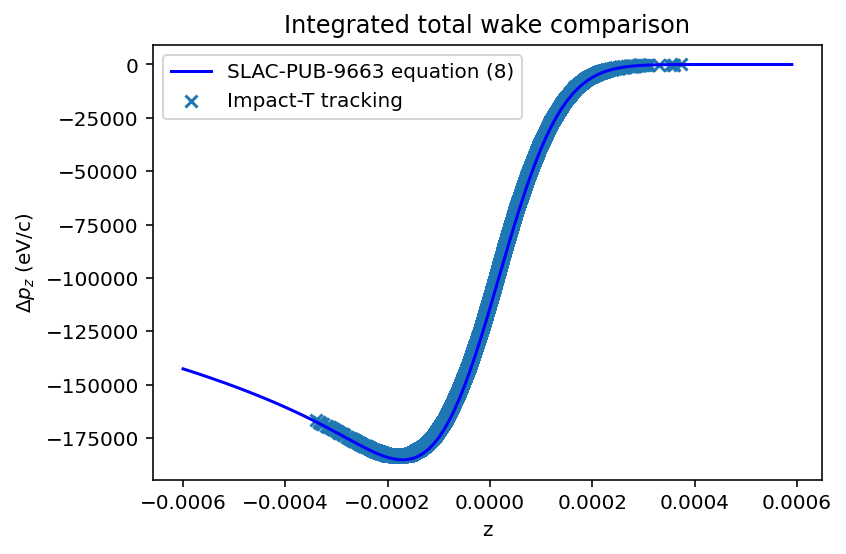

In [19]:
plt.xlabel('z')
plt.ylabel('$\Delta p_z$ (eV/c)')
plt.scatter(PF['delta_z'], PF['pz']- PF['max_pz'], marker='x', label='Impact-T tracking')
plt.plot(zlist, Qtot*np.array([total_bane_wake(z) for z in zlist]), color='blue', label='SLAC-PUB-9663 equation (8)')
plt.title('Integrated total wake comparison')
plt.legend()

# Comparison with Wakefield file

Many codes will use a wakefield file, with a list of z and single particle wake in V/C

In [20]:
wfile = 'Sz_p5um_10mm_per35mm_cell.sdds'
reffile = os.path.join(template_dir, 'wakefield', wfile)
reffile 

'/Users/chrisonian/Code/GitHub/lume-impact/impact/../templates/wakefield/Sz_p5um_10mm_per35mm_cell.sdds'

In [21]:
!head -n 8 ../../templates/wakefield/Sz_p5um_10mm_per35mm_cell.sdds

SDDS1
&column name=z, units=m, type=double,  &end
&column name=W, units=V/C, type=double,  &end
&column name=t, units=s, type=double,  &end
&data mode=ascii, &end
! page number 1
               20001
0.00000000e+000  9.22430234e+012  0.00000000e+000 


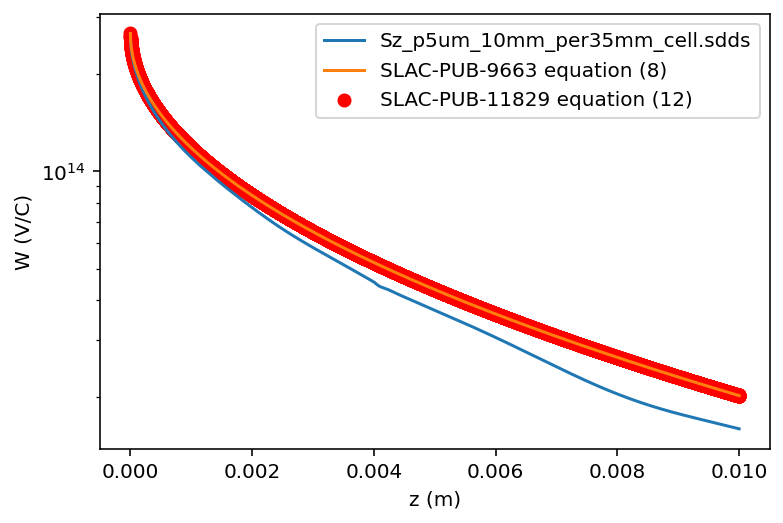

In [22]:
# Load the file
edat = np.loadtxt(reffile, skiprows=7).T
zw = edat[0]
dzw = np.mean(np.diff(zw))
W_from_file = edat[1]/35e-3 # Convert to per m

plt.ylabel('W (V/C)')
plt.xlabel('z (m)')
plt.yscale('log')
plt.plot(zw, W_from_file, label=wfile)
plt.plot(zw, np.array([bane_wake(z) for z in zw]), label='SLAC-PUB-9663 equation (8)')
plt.scatter(zw, np.array([bane_wake(z) for z in zw]), label='SLAC-PUB-11829 equation (12)', color='red')
plt.legend()

In [23]:
def total_wake_from_file(z):
    return np.sum(W_from_file* density(zw + z)*dzw)
total_wake_from_file(0) * 1e-9
    

106087.97587646772

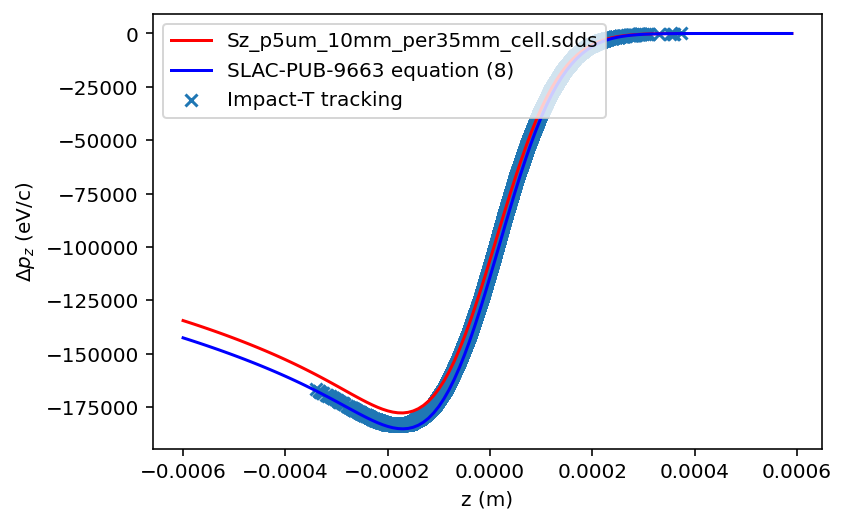

In [24]:
plt.xlabel('z (m)')
plt.ylabel('$\Delta p_z$ (eV/c)')
plt.scatter(PF['delta_z'], PF['pz']- PF['max_pz'], marker='x', label='Impact-T tracking')
plt.plot(zlist, Qtot*np.array([total_wake_from_file(z) for z in zlist]), color='red', label=wfile)
plt.plot(zlist, Qtot*np.array([total_bane_wake(z) for z in zlist]), color='blue', label='SLAC-PUB-9663 equation (8)')
plt.legend()